In [1]:
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

transform = transforms.Compose([
    transforms.Resize((1130, 1130)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.ImageFolder(
    root='data',
    transform=transform
)

###Stratified split images
train_proportion = 0.6
val_proportion = 0.2

sss = StratifiedShuffleSplit(n_splits=1, test_size=1 - train_proportion, random_state=69)

targets = [target for _, target in dataset.samples]
indices = list(range(len(targets)))

for train_indices, non_train_indices in sss.split(indices, targets):
    pass

non_train_proportion = 1 - train_proportion
relative_val_size = val_proportion /non_train_proportion
sss_non_train = StratifiedShuffleSplit(n_splits=1, test_size=relative_val_size, random_state=69)

non_train_targets = [targets[i] for i in non_train_indices]
for val_indices, test_indices in sss_non_train.split(non_train_indices, non_train_targets):
    pass


val_indices = [non_train_indices[i] for i in val_indices]
test_indices = [non_train_indices[i] for i in test_indices]

stratified_train = Subset(dataset, train_indices)
stratified_val = Subset(dataset, val_indices)
stratified_test = Subset(dataset, test_indices)

train_loader = DataLoader(stratified_train, batch_size=16, shuffle=True)
val_loader = DataLoader(stratified_val, batch_size=16, shuffle=False)
test_loader = DataLoader(stratified_test, batch_size=16, shuffle=False)

###Neural Network 
class NeuralNetwork(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(NeuralNetwork, self).__init__()
        self.dropout_rate = dropout_rate
        # Block 1
        self.conv1_1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.bn1_1 = nn.BatchNorm2d(16)
        self.conv1_2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn1_2 = nn.BatchNorm2d(16)
        self.conv1_3 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)
        self.bn1_3 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2,2)
        self.dropout1 = nn.Dropout(self.dropout_rate)
        
        # Block 2
        self.conv2_1 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.bn2_1 = nn.BatchNorm2d(32)
        self.conv2_2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2_2 = nn.BatchNorm2d(32)
        self.conv2_3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.bn2_3 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(self.dropout_rate)
        self.pool2 = nn.MaxPool2d(2,2)     
        
        # Block 3
        self.conv3_1 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.bn3_1 = nn.BatchNorm2d(64)
        self.conv3_2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3_2 = nn.BatchNorm2d(64)
        self.conv3_3 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.bn3_3 = nn.BatchNorm2d(64)
        self.dropout3 = nn.Dropout(self.dropout_rate)
        self.pool3 = nn.MaxPool2d(2,2)     
        
        # Block 4
        self.conv4_1 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_1 = nn.BatchNorm2d(128)
        self.conv4_2 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_2 = nn.BatchNorm2d(128)
        self.conv4_3 = nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1)
        self.bn4_3 = nn.BatchNorm2d(128)
        self.dropout4 = nn.Dropout(self.dropout_rate)
        self.pool4 = nn.MaxPool2d(2,2)     

        flattened_size = 128 * 70 * 70 
        self.fc1 = nn.Linear(flattened_size, 32)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(32, 1)


    def forward(self, x):
        # Block 1
        x = F.relu(self.bn1_1(self.conv1_1(x)))
        x = F.relu(self.bn1_2(self.conv1_2(x)))
        x = F.relu(self.bn1_3(self.conv1_3(x)))
        x = self.pool1(x)
        x = self.dropout1(x)
        
        # Block 2
        x = F.relu(self.bn2_1(self.conv2_1(x)))
        x = F.relu(self.bn2_2(self.conv2_2(x)))
        x = F.relu(self.bn2_3(self.conv2_3(x)))
        x = self.pool2(x)
        x = self.dropout2(x)
        
        # Block 3
        x = F.relu(self.bn3_1(self.conv3_1(x)))
        x = F.relu(self.bn3_2(self.conv3_2(x)))
        #x = F.relu(self.bn3_3(self.conv3_3(x)))
        x = self.pool3(x)
        x = self.dropout3(x)

        # Block 4
        x = F.relu(self.bn4_1(self.conv4_1(x)))
        x = F.relu(self.bn4_2(self.conv4_2(x)))
        #x = F.relu(self.bn4_3(self.conv4_3(x)))
        x = self.pool4(x)
        x = self.dropout4(x)
        
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x





Using device: cuda


In [3]:
[len(stratified_train), len(stratified_val), len(stratified_test)]

[3537, 1179, 1180]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


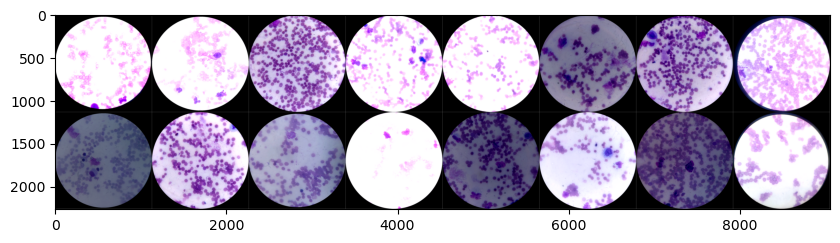

Labels: 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0


In [4]:
###Check batch images
def imshow(img):
    plt.figure(figsize=(10,10))
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(val_loader)
images, labels = next(dataiter) 

imshow(torchvision.utils.make_grid(images))

print('Labels:', ' '.join(f'{labels[j].item()}' for j in range(images.shape[0])))



In [6]:
model = NeuralNetwork().to(device)
criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=2,
    verbose=True,
    threshold=0.01,
    threshold_mode='rel'
)
num_epochs = 100
checkpoint_dir = '/home/chris/Documents/chagas/checkpoints/final'
log_file_path = os.path.join(checkpoint_dir, 'a_training_log.txt')

train_losses = []
val_losses = []

best_val_loss = float('inf') 

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

for epoch in range(num_epochs):
    model.train()
    
    total_train_loss = 0.0  
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))
            total_val_loss += loss.item()

    average_train_loss = total_train_loss / len(train_loader)
    average_val_loss = total_val_loss / len(val_loader)

    train_losses.append(average_train_loss)
    val_losses.append(average_val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}")

    with open(log_file_path, 'a') as log_file:
        log_file.write(f"Epoch [{epoch+1}/{num_epochs}], Average Train Loss: {average_train_loss:.4f}, Average Val Loss: {average_val_loss:.4f}\n")

    scheduler.step(average_val_loss)

    recent_checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'train_losses': train_losses,
        'val_losses': val_losses
    }
    torch.save(recent_checkpoint, f'checkpoint_epoch_{epoch}.pth')

    if average_val_loss < best_val_loss:
        best_val_loss = average_val_loss
        best_model_checkpoint = recent_checkpoint
        torch.save(best_model_checkpoint, 'best_model_checkpoint.pth')

    #params = sum([p.flatten().size()[0] for p in list(model.parameters())])
    #print("Params: ",params)


Epoch [1/100], Average Train Loss: 1.4623, Average Val Loss: 0.6043
Epoch [2/100], Average Train Loss: 0.5583, Average Val Loss: 0.5848
Epoch [3/100], Average Train Loss: 0.5075, Average Val Loss: 0.4727
Epoch [4/100], Average Train Loss: 0.4827, Average Val Loss: 0.4677
Epoch [5/100], Average Train Loss: 0.4460, Average Val Loss: 0.4958
Epoch [6/100], Average Train Loss: 0.4500, Average Val Loss: 0.5553
Epoch [7/100], Average Train Loss: 0.4168, Average Val Loss: 0.4171
Epoch [8/100], Average Train Loss: 0.3372, Average Val Loss: 0.4333
Epoch [9/100], Average Train Loss: 0.3037, Average Val Loss: 0.2903
Epoch [10/100], Average Train Loss: 0.2879, Average Val Loss: 0.2810
Epoch [11/100], Average Train Loss: 0.2868, Average Val Loss: 0.2923
Epoch [12/100], Average Train Loss: 0.3643, Average Val Loss: 0.2527
Epoch [13/100], Average Train Loss: 0.2839, Average Val Loss: 0.2686
Epoch [14/100], Average Train Loss: 0.2636, Average Val Loss: 0.2462
Epoch [15/100], Average Train Loss: 0.2500,

In [8]:
###Load checkpoint
def load_checkpoint(model, optimizer, filename):
    start_epoch = 0
    if os.path.isfile(filename):
        print("Loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("Loaded checkpoint '{}' (epoch {})".format(filename, checkpoint['epoch']))
    else:
        print("No checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

model = NeuralNetwork().to(device)
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    model = nn.DataParallel(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = '/home/chris/Documents/chagas/checkpoints/final/best_model_checkpoint.pth'  
model, optimizer, start_epoch = load_checkpoint(model, optimizer, checkpoint_path)

Loading checkpoint '/home/chris/Documents/chagas/checkpoints/final/best_model_checkpoint.pth'
Loaded checkpoint '/home/chris/Documents/chagas/checkpoints/final/best_model_checkpoint.pth' (epoch 80)


In [ ]:
###Continue from checkpoint
num_epochs = 100

for epoch in range(start_epoch, num_epochs):
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels.unsqueeze(1).type_as(outputs))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():}")

    checkpoint = {
        'epoch': epoch + 1,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')


Confusion Matrix:
 [[556  80]
 [ 23 520]]
Accuracy: 0.9126378286683631
Precision: 0.8666666666666667
Recall (True Positive Rate): 0.9576427255985267
F1 Score: 0.9098862642169728
Specificity (True Negative Rate): 0.8742138364779874


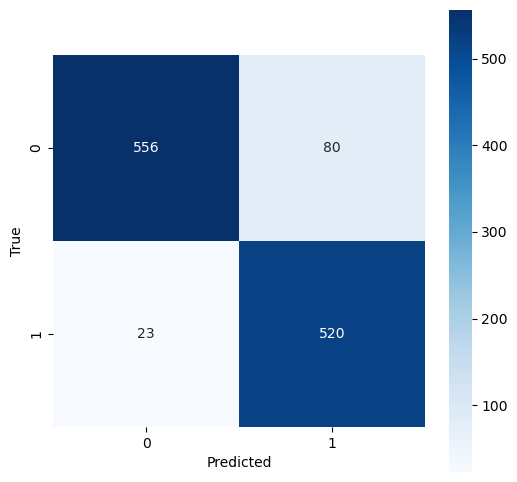

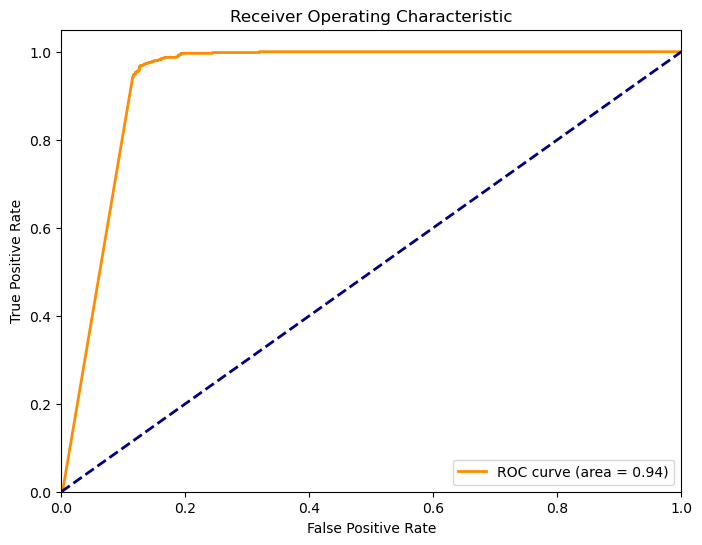

Area Under the ROC Curve (AUC): 0.94


: 

In [10]:
###Evaluation
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

model.eval()

true_labels = []
predictions = []
prob_scores = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probabilities = sigmoid(outputs.cpu().numpy())  
        predicted = outputs.round().cpu().numpy()  

        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted)
        prob_scores.extend(probabilities.squeeze()) 

true_labels = np.array(true_labels)
predictions = np.array(predictions)

cm = confusion_matrix(true_labels, predictions)
print("Confusion Matrix:\n", cm)

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions) 
f1 = f1_score(true_labels, predictions)
TN, FP, FN, TP = cm.ravel()
specificity = TN / (TN + FP)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall (True Positive Rate):", recall)
print("F1 Score:", f1)
print("Specificity (True Negative Rate):", specificity)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', square=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

roc_auc = roc_auc_score(true_labels, prob_scores)
fpr, tpr, thresholds = roc_curve(true_labels, prob_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(f'Area Under the ROC Curve (AUC): {roc_auc:.2f}')

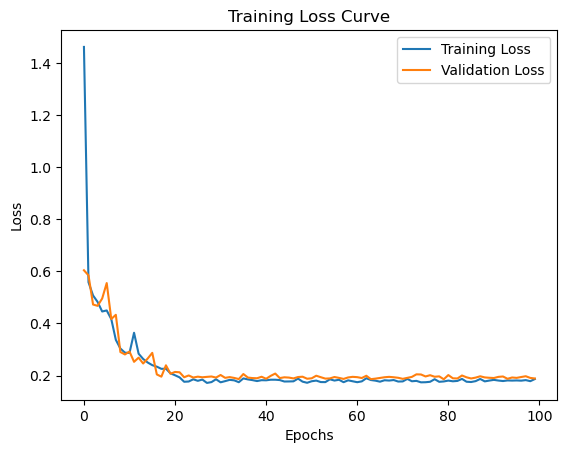

In [10]:
###Train Loss Curve
plt.plot(train_losses,label='Training Loss')
plt.plot(val_losses,label='Validation Loss')
plt.title('Training Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()